<a href="https://colab.research.google.com/github/tahlberg/AmesHousingMarket-Regression/blob/main/AmesHousingMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

#Get file system interaction
from google.colab import files

#Upload kaggle.json for download auth
files.upload()

#This is needed to support the kaggle api
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
import pandas as pd
import numpy as np

#download dataset from kaggle using kaggle.json auth tokens
!kaggle competitions download -c house-prices-advanced-regression-techniques

!unzip -n house-prices-advanced-regression-techniques train.csv test.csv

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 78.8MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: test.csv                
  inflating: train.csv               


In [27]:
from sklearn import preprocessing
#Define functions

#Encode labels with LabelEncoder
def encode_labels(df, name):
    le = preprocessing.LabelEncoder()
    le.fit(df.drop_duplicates(subset=name)[name])
    df[name]=le.transform(df[name])

def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})

    return dict_x

In [28]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [29]:
#Time to do preprocessing on training data

#Start by previewing the train dataframe
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [30]:
#First we remove the ID because it doesn't contribute to the data
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [42]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Skewness: 1.882876
Kurtosis: 6.536282


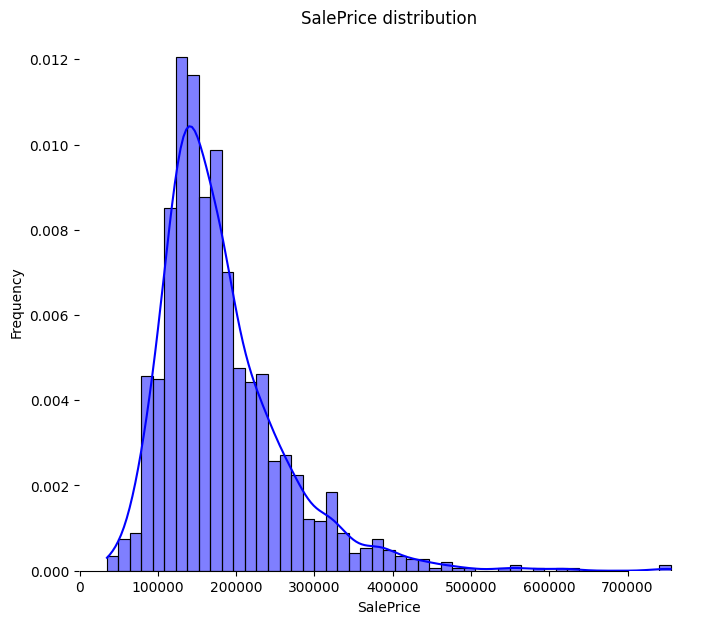

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

#First let's check the skew on our SalePrice using a histogram
fig, ax, = plt.subplots(figsize=(8,7))
sns.histplot(train['SalePrice'],stat='frequency',kde=True,color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(title="SalePrice distribution")
sns.despine(trim=True,left=True)

#As well as print the skew and kursosis from the dataframe
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

<ipython-input-32-68556476562a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


<Axes: >

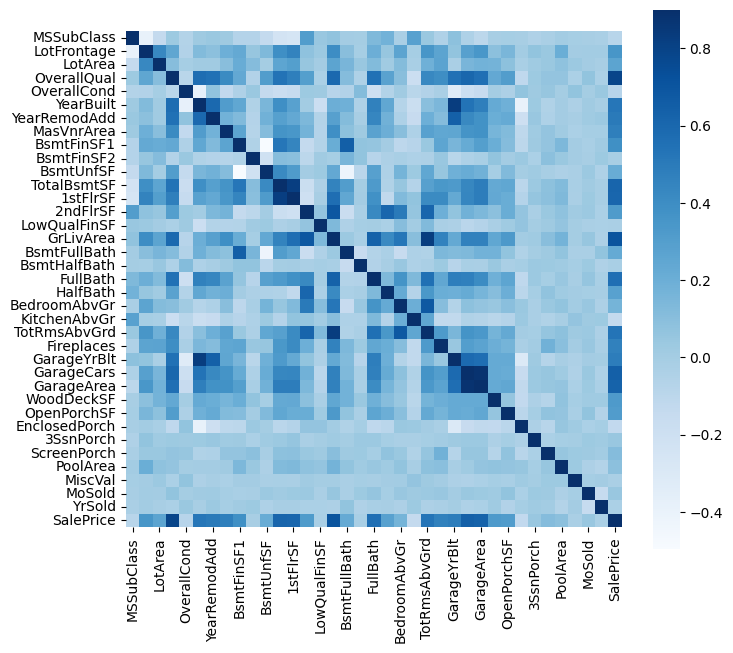

In [32]:
#Let's find the correlation matrix of our features.
#The remaining exploratory data analysis was done via Tableau
corr = train.corr()
plt.subplots(figsize=(8,7))
sns.heatmap(corr, vmax=0.9, cmap="Blues",square=True)

In [33]:
#Let's correct the skewness so we can have normally distributed data
train['SalePrice']=np.log1p(train['SalePrice'])

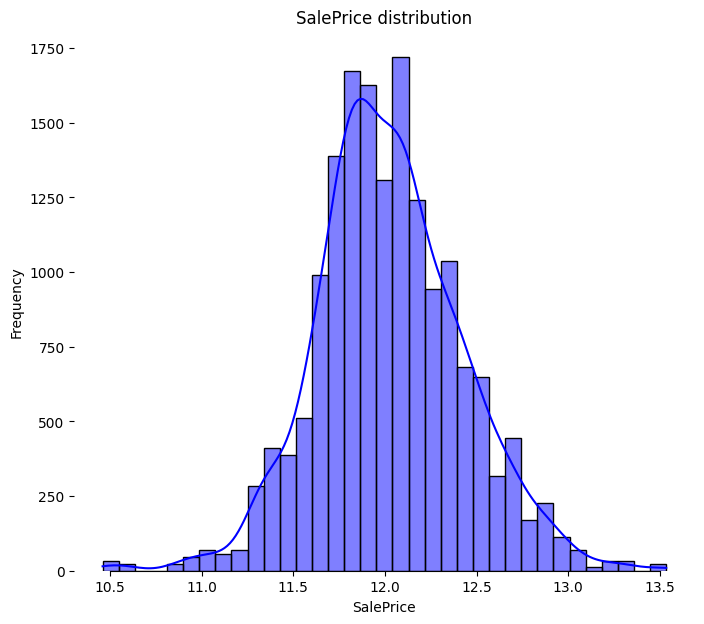

In [34]:
from scipy.stats import norm
fig, ax, = plt.subplots(figsize=(8,7))
sns.histplot(train['SalePrice'],stat='frequency',kde=True,color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(title="SalePrice distribution")
sns.despine(trim=True,left=True)

In [44]:
train_y = train['SalePrice'].reset_index(drop=True)
train_x = train.drop(['SalePrice'], axis=1)
test_x = test
all_x = pd.concat([test_x, test_x]).reset_index(drop=True)

In [45]:
miss = percent_missing(all_x)
df_miss = sorted(miss.items(), key=lambda x: x[1], reverse=True)
df_miss[0:10]

[('PoolQC', 99.79),
 ('MiscFeature', 96.5),
 ('Alley', 92.67),
 ('Fence', 80.12),
 ('FireplaceQu', 50.03),
 ('LotFrontage', 15.56),
 ('GarageYrBlt', 5.35),
 ('GarageFinish', 5.35),
 ('GarageQual', 5.35),
 ('GarageCond', 5.35)]

In [46]:
#Use the dataset description to find a typical value to fill NA values with
all_x['MSZoning'] = all_x.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0])) #Using lambda function to apply the mode zoning type based on subclass
all_x['Electrical'].fillna("SBrkr",inplace=True)
all_x['Functional'].fillna("Typ",inplace=True)
all_x['KitchenQual'].fillna("TA",inplace=True)
all_x['Exterior1st'].fillna(all_x['Exterior1st'].mode()[0],inplace=True) #Use mode
all_x['Exterior2nd'].fillna(all_x['Exterior2nd'].mode()[0],inplace=True)
all_x['SaleType'].fillna(all_x['SaleType'].mode()[0],inplace=True)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
  all_x[col].fillna(0,inplace=True)
for col in ('PoolQC','GarageYrBlt', 'GarageArea', 'GarageCars','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
  all_x[col].fillna(0,inplace=True)
all_x['LotFrontage'] = all_x.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median())) #Using lambda function to apply the median lotfrontage based on neighborhood

#Now for missing data with no obvious filler
for i in all_x.columns:
  if all_x[i].dtype == object:
      all_x[i].fillna("None",inplace=True)

for i in train_x.columns:
  if train_x[i].dtype in ['float','float64','int','int64']:
    all_x[i].fillna(0,inplace=True)

In [47]:
miss = percent_missing(all_x)
df_miss = sorted(miss.items(), key=lambda x: x[1], reverse=True)
df_miss[0:10]

[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]